# Генерируем синусоиды
Качественная генерация с нуля изображений с большим разрешением требует длительных расчетов (дни, недели) и мощных компьютеров. Мы посмотрим лишь на простые примеры. Сегодня сгенерируем одномерную функцию (синусоиду), на следующем занятии - небольшие изображения.      

Наша цель сегодня - научиться генерировать графики функции, похожей на синусоиду. Синусоиду можно описать как

$ y= A * sin( B * x +C) $
где A - амплитуда, B - частота и C - фаза синусоиды.

Надо создать примеры "настоящих" синусоид, на которых будем обучать нашу GAN. Для простоты амплитуду менять не будем, только фазу и частоту.


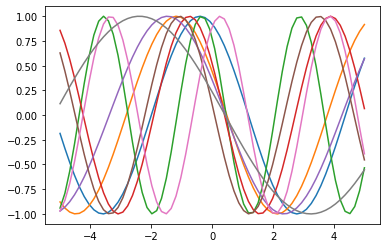

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint, uniform

SAMPLE_LEN = 64       # N число точек в графике кривой
NOISE_LEN=8           # размер латентных переменных
SAMPLE_SIZE = 32768//1   # число кривых для обучения
X_MIN = -5.0          # минимальное
X_MAX = 5.0           # и максимальное значение аргумента

# Значения аргумента для точек графика
X_COORDS = np.linspace(X_MIN , X_MAX, SAMPLE_LEN)

# Обучающие данные - синусоиды
SAMPLE = np.zeros((SAMPLE_SIZE, SAMPLE_LEN)) # хранилище обучающих данных
for i in range(0, SAMPLE_SIZE): # в цикле по количеству примеров обучения
    b = uniform(0.5, 2.0) # случайно выбираем частоту
    c = uniform(np.math.pi) # и фазу (амплитуду не изменяем)
    SAMPLE[i] = np.array([np.sin(b*x + c) for x in X_COORDS]) # создаем синусоиду

# нарисуем первые 8 примеров
fig, axis = plt.subplots(1, 1) #
for i in range(8): #
    axis.plot(X_COORDS, SAMPLE[i]) #

**Дискриминатор** имеет N (число точек графика) входов и один выход. Для настоящих синусоид желаемый выход равен 1, для ненастоящих 0. Для лучшей обобщающей способности будем использовать слои dropout. Вы можете сделать свою внутреннюю архитектуру, при условии соблюдения размерности входов\выходов.

In [ ]:
from keras.models import Sequential # модели keras для последовательного подключения слоев нейронной сети без разветвлений
from keras.layers import Dense, Dropout, LeakyReLU # слои нейронной сети
from keras.optimizers import Adam
DROPOUT = Dropout(0.4)        # величина dropout
discriminator = Sequential() # создаем пустую модель дискриминатора
# и добавляем в нее слои
discriminator.add(Dense(2*SAMPLE_LEN,#  1ый полносвязный слой. число нейронов можно менять
                        activation="relu")) # функция активации для него
discriminator.add(DROPOUT) # слой dropout
discriminator.add(Dense(2*SAMPLE_LEN, activation="relu")) # 2ой полносвязный слой, можно менять
discriminator.add(DROPOUT) # еще слой dropout
discriminator.add(Dense(1, activation = "sigmoid")) # последний выходной полносвязный слой, 1 нейрон.
# прочие параметры дискриминатора
optimizer=Adam(learning_rate=0.005) # можно задать параметры обучения, пусть дискриминатор обучается быстрее (по умолчанию 0.001)
discriminator.compile(optimizer = optimizer, # метод обучения
                      loss = "binary_crossentropy", # функция ошибки
                      metrics = ["accuracy"]) # функция для тестирования (метрика)


**Генератор** в некотором смысле это зеркальное отражение дискриминатора. Он принимает некоторый вход - шум, а возвращает N (число точек графика) выходов, которые затем поступают на дискриминатор. Поскольку эти выходы описывают график кривой, для синусоиды нужно чтобы они были в диапазоне -1 до +1. Используем, например, гипертангенс в качестве функции активации последнего слоя. На других слоях будем использовать, скажем, leaky-relu функцию,которая кусочно-линейная, а вообще, попробуйте и другие.

In [ ]:
LEAKY_RELU = LeakyReLU(0.2)   # коэффициент отрицательной части LeakyReLU
generator = Sequential() # создаем пустую модель генератора
# и добавляем в нее слои
generator.add(Dense(SAMPLE_LEN)) # 1ый полносвязный слой, можно менять
generator.add(LEAKY_RELU) # функция активации для него
generator.add(Dense(512)) # 2ой полносвязный слой, можно менять
generator.add(LEAKY_RELU) # функция активации для него
generator.add(Dense(SAMPLE_LEN, activation = "tanh")) # последний выходной полносвязный слой, SAMPLE_LEN нейронов.
# прочие параметры генератора
generator.compile(optimizer = "adam", # метод обучения
                  loss = "mse", # функция ошибки. Это не классификатор, поэтому mse подойдет.
                  metrics = ["accuracy"]) # функция для тестирования (метрика)


Теперь создадим сам **GAN** - объединение  генератора и дискриминатора.

In [ ]:
gan = Sequential() # пустая его модель
gan.add(generator) # добавляем генератор
gan.add(discriminator) # добавляем дискриминатор (не перепутайте порядок)
gan.compile(optimizer = "adam", # метод обучения
            loss = "binary_crossentropy", # функция ошибки, очевидно такая же как у дискриминатора.
            metrics = ["accuracy"]) # метрика

In [ ]:
#EPOCHS = 128 # число эпох
#BATCH =64 # размер пакета
NOISE = uniform(X_MIN, X_MAX, size = (SAMPLE_SIZE, NOISE_LEN)) # шум-вход в генератор, у нас будет одинаковое количество настоящих и сгенерированных примеров
ONES = np.ones((SAMPLE_SIZE)) # указания учителя для настоящих примеров, единицы
ZEROS = np.zeros((SAMPLE_SIZE)) # указания учителя для сгенерированных примеров, нолики

GENERATOR PRETRAINING
1/1 [==============================] - 0s 148ms/step


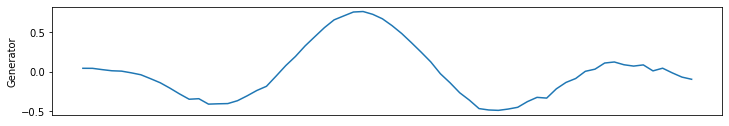

In [ ]:
# предобучение генератора
BATCH =64 # размер пакета
print('GENERATOR PRETRAINING')
generator.fit(NOISE,SAMPLE,epochs=1,batch_size=BATCH)

# пример выхода генератора
y = generator.predict(uniform(X_MIN, X_MAX, size = (1, NOISE_LEN)))[0] #
fig = plt.figure(figsize = (12, 2))
ax = fig.subplots()  #
ax.xaxis.set_visible(False) #
plt.plot(X_COORDS, y) #
plt.ylabel("Generator") #
plt.show()

In [ ]:
# предобучение дискриминатора
EPOCHS_DISCR=20 # число эпох предобучения дискриминатора
BATCH =64 # размер пакета
print('DISCRIMINATOR PRETRAINING')
print("epoch | dis. loss | dis. acc")
print("------+-----------+---------")
NOISE_SAMPLE = uniform(X_MIN, X_MAX, size = (SAMPLE_SIZE, SAMPLE_LEN)) # примеры шума для дискриминатора
#
for e in range(EPOCHS_DISCR): # в цикле по количеству эпох
    for k in range(SAMPLE_SIZE//BATCH): # в цикле по количеству пакетов в одной эпохе
        #
        n = randint(0, SAMPLE_SIZE, size = BATCH) # случайно выбираем для пакета примеры входа-шума в генератор
        p = generator.predict(NOISE[n]) # считаем выходы генератора для каждого выбранного входа и записываем их в пакет
        x = np.concatenate((SAMPLE[n],NOISE_SAMPLE[n], p)) # добавляем в пакет случайно выбранные настоящие примеры SAMPLE и шумовые NOISE_SAMPLE
        y = np.concatenate((ONES[n],ZEROS[n],ZEROS[n])) # указания учителя для них: настощие синусоиды - 1, сгенерированные и шум - 0
        d_result = discriminator.train_on_batch(x, y) # обучаем дискриминатор на этом пакете
    print(f" {e:04n} |  {d_result[0]:.5f}  |  {d_result[1]:.5f} | ")


Выходные данные были обрезаны до нескольких последних строк (5000).
2/2 [==============================] - 0s 4ms/step
 0010 |  0.00001  |  1.00000 | 
2/2 [==============================] - 0s 8ms/step
 0011 |  0.00000  |  1.00000 | 
2/2 [==============================] - 0s 6ms/step
 0012 |  0.00001  |  1.00000 | 
2/2 [==============================] - 0s 8ms/step
 0013 |  0.00000  |  1.00000 | 
2/2 [==============================] - 0s 7ms/step
 0014 |  0.00014  |  1.00000 | 
2/2 [==============================] - 0s 4ms/step
 0015 |  0.00002  |  1.00000 | 
2/2 [==============================] - 0s 11ms/step
 0016 |  0.00002  |  1.00000 | 
2/2 [==============================] - 0s 5ms/step
 0017 |  0.00004  |  1.00000 | 
2/2 [==============================] - 0s 17ms/step
 0018 |  0.00000  |  1.00000 | 
2/2 [==============================] - 0s 12ms/step
 0019 |  0.00001  |  1.00000 | 


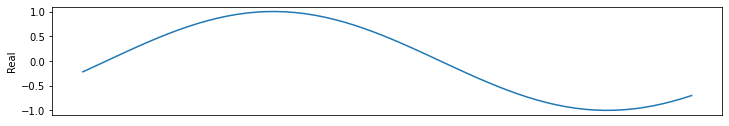

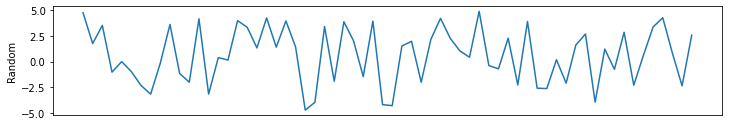

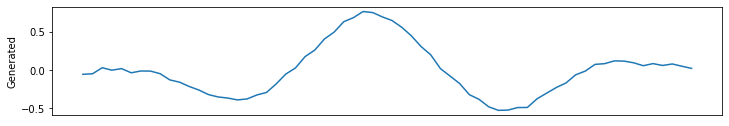

In [ ]:

# пример настоящей синусоиды, случайного примера и выхода генератора, которые были в обучении дискриминатора
Text=['Real','Random','Generated']
for i in range(3):
    tmp=x[0+i*BATCH]
    fig = plt.figure(figsize = (12, 2))
    ax = fig.subplots()  #
    ax.xaxis.set_visible(False) #
    plt.plot(X_COORDS, tmp) #
    plt.ylabel(Text[i]) #
    plt.show()

In [ ]:
# Обучение GAN
EPOCHS = 32 # число эпох обучения GAN
BATCH =64 # размер пакета
print('GAN TRAINING')
print("epoch | dis. loss | dis. acc | gen. loss | gen. acc")
print("------+-----------+----------+-----------+----------")

for e in range(EPOCHS): # в цикле по количеству эпох
    for k in range(SAMPLE_SIZE//BATCH): # в цикле по количеству пакетов в одной эпохе
        #
        n = randint(0, SAMPLE_SIZE, size = BATCH) # случайно выбираем для пакета примеры входа-шума в генератор
        #
        p = generator.predict(NOISE[n]) # считаем выходы генератора для каждого выбранного входа и записываем их в пакет
        x = np.concatenate((SAMPLE[n], p)) # добавляем в пакет случайно выбранные настоящие примеры
        y = np.concatenate((ONES[n], ZEROS[n])) # указания учителя для них, первая половина - настоящие 1, вторая - сгенерированные 0
        d_result = discriminator.train_on_batch(x, y) # обучаем дискриминатор на этом пакете
        discriminator.trainable = False # отключаем возможность обучения для дискриминатора
        # обучаем на сгенерированной половине пакета GAN в целом, но обучаться будет только его первая часть (генератор).
        # при этом указания учителя - единицы, так как мы хотим, чтобы на этих сгенерированных примерах
        # дискриминатор говорил что это настоящие синусоиды
        g_result = gan.train_on_batch(NOISE[n], ONES[n]) #
        discriminator.trainable = True # возвращаем возможность обучения для дискриминатора
    # печатаем информацию о прогрессе обучения
    print(f" {e:04n} |  {d_result[0]:.5f}  |  {d_result[1]:.5f} |  {g_result[0]:.5f}  |  {g_result[1]:.5f}")

    if e % 5 == 3: # каждые несколько эпох  строим графики того, что сгенерировал генератор

        fig = plt.figure(figsize = (12, 2))
        ax = fig.subplots() #
        plt.plot(X_COORDS, p[-1]) #
        ax.xaxis.set_visible(False) #
        plt.ylabel(f"Epoch: {e}") #
        #ax_index += 1 #
        plt.show()

Протестируйте генератор несколько раз. Если обучение действительно было, то он должен выдавать нечто, хоть сколько-нибудь похожее на синусоиду.

Даже такой примитивный пример не получится быстро обучить генерации безупречных синусоид, всегда будут заметные погрешности.

В реальной жизни обучением GANов с нуля занимаются только владельцы мощных компьютеров, остальные же пользуются их результатами, **дообучая** GANы под свои данные.

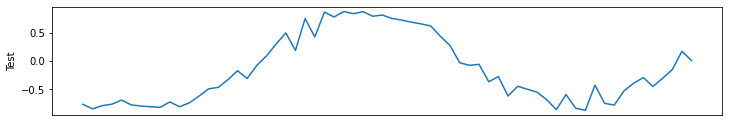

In [ ]:
# Тест обученного генератора из GAN
y = generator.predict(uniform(X_MIN, X_MAX, size = (1, NOISE_LEN)))[0] #
fig = plt.figure(figsize = (12, 2))
ax = fig.subplots()  #
ax.xaxis.set_visible(False) #
plt.plot(X_COORDS, y) #
plt.ylabel("Test") #
plt.show()

# Заключение
Сегодня существует множество разных уже обученных GANов, которые могут генерировать изображения, музыку, речь, текст и другие типы данных.

Придумано много модификаций, которые улучшают работу GANов, обычно используют уже заранее обученные сети для дискриминатора и генератора. На следующих занятиях мы познакомимся с некоторыми из них.
